## <font color = 'orange'> **04-machine_learning1 branch**

Random Forest - Cross-Validation Scores: [0.99997702 1.         1.         0.99997702 1.        ]
Random Forest - Average Cross-Validation Score: 1.00

Random Forest - Model Accuracy: 1.00
Random Forest - Mean Absolute Error: 0.00



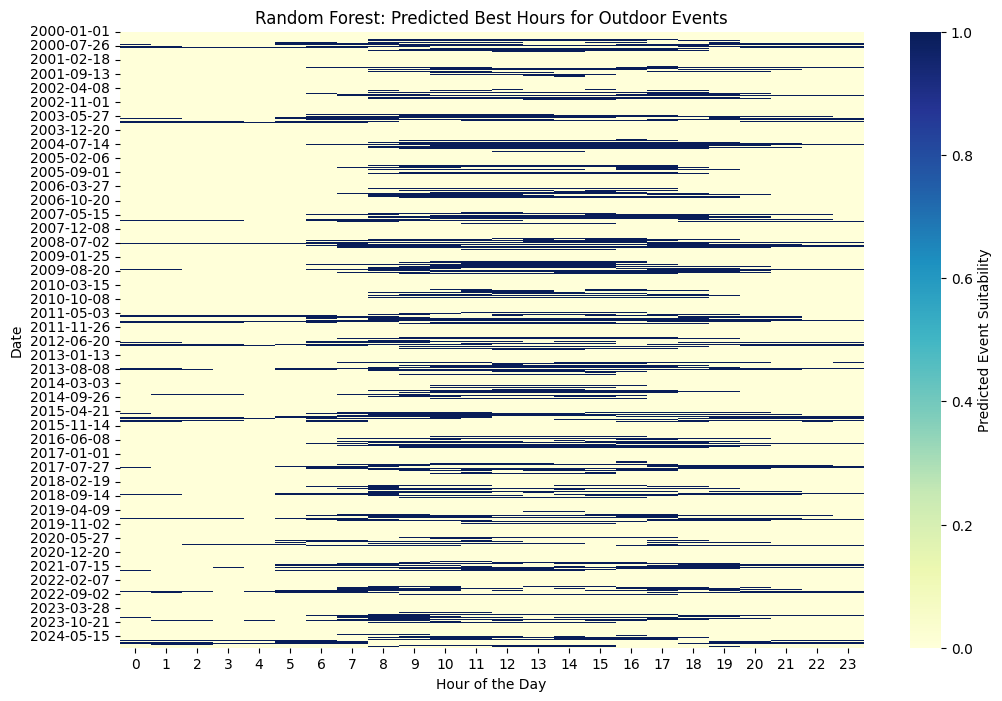

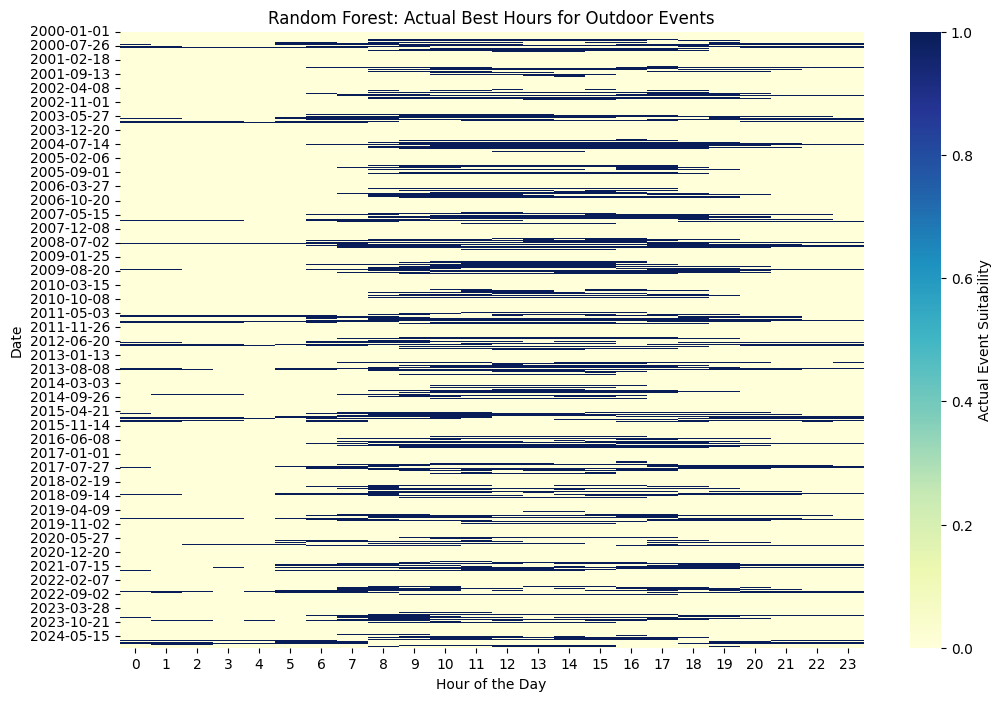

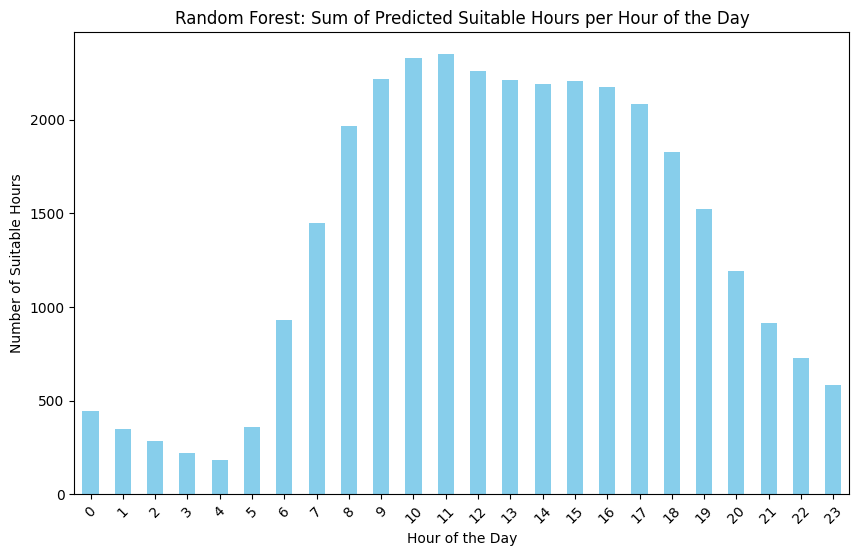

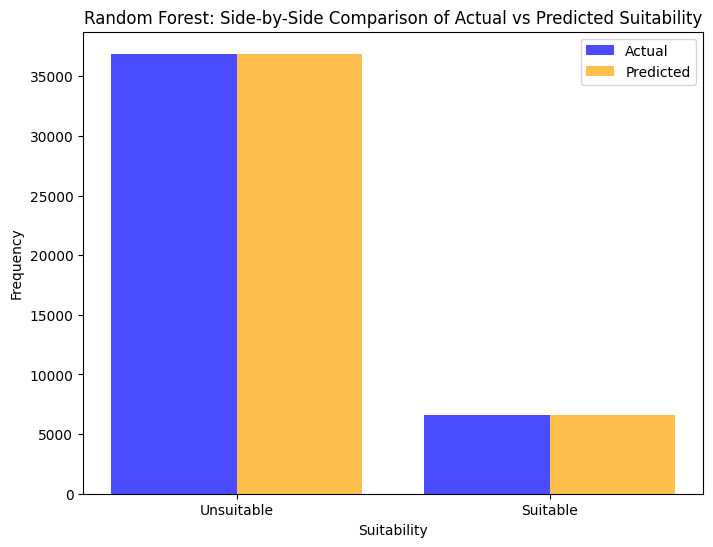

Gradient Boosting - Cross-Validation Scores: [1.         1.         1.         0.99997702 1.        ]
Gradient Boosting - Average Cross-Validation Score: 1.00

Gradient Boosting - Model Accuracy: 1.00
Gradient Boosting - Mean Absolute Error: 0.00



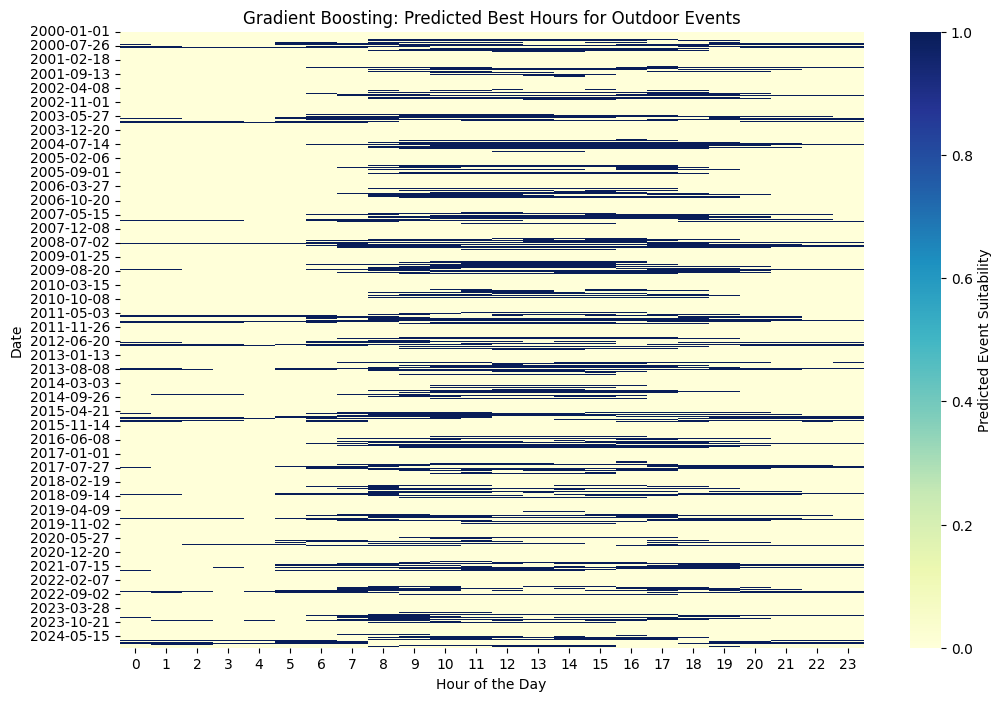

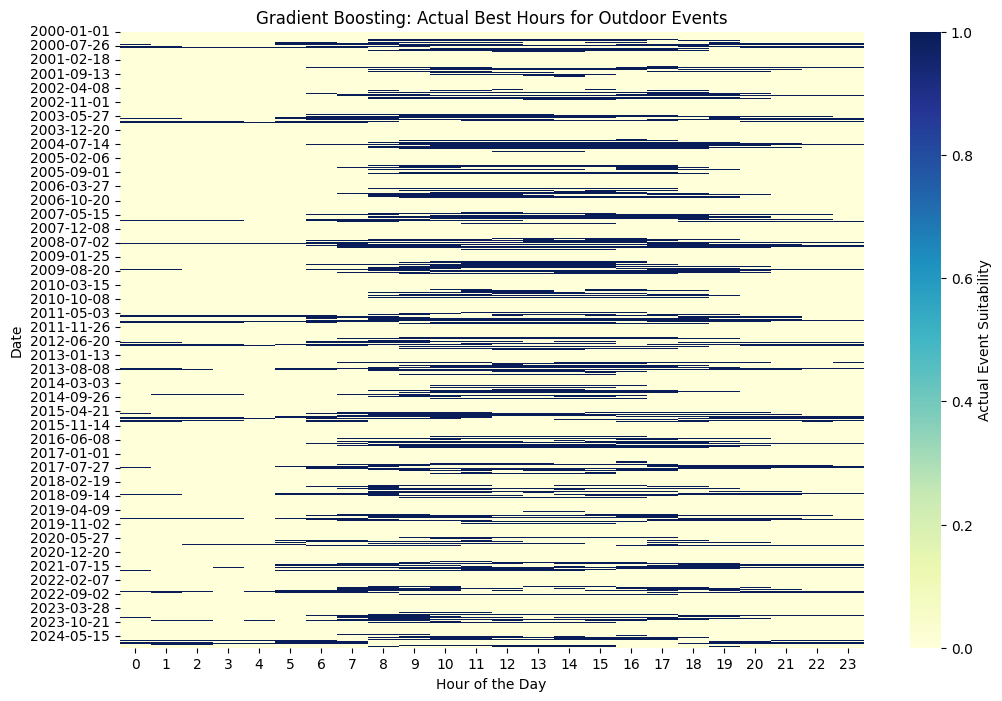

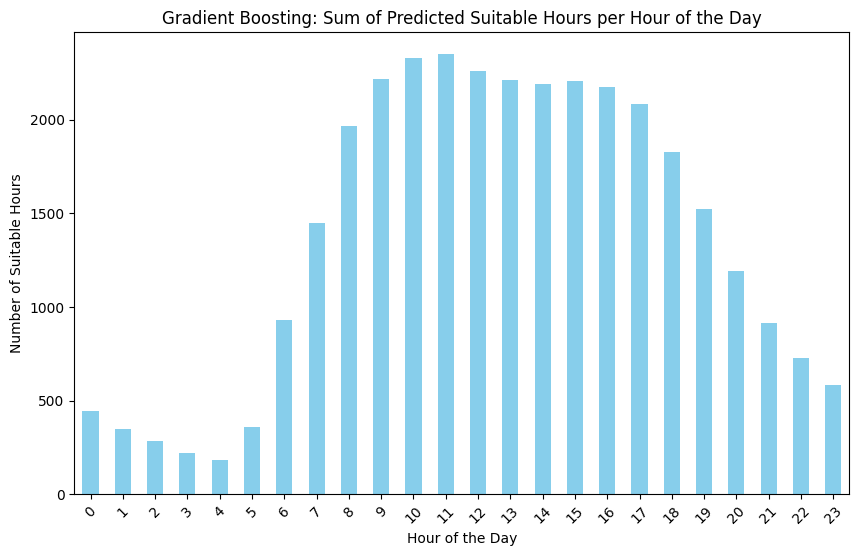

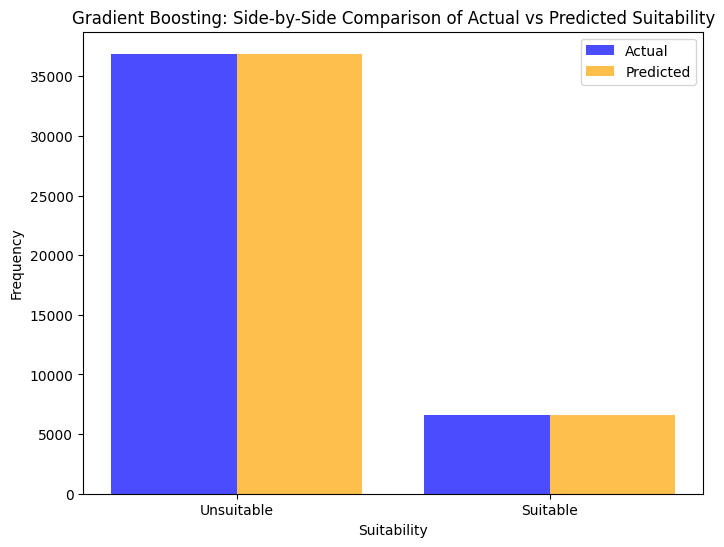

Logistic Regression - Cross-Validation Scores: [0.90222212 0.90323322 0.89792495 0.89684491 0.88636625]
Logistic Regression - Average Cross-Validation Score: 0.90

Logistic Regression - Model Accuracy: 0.90
Logistic Regression - Mean Absolute Error: 0.10



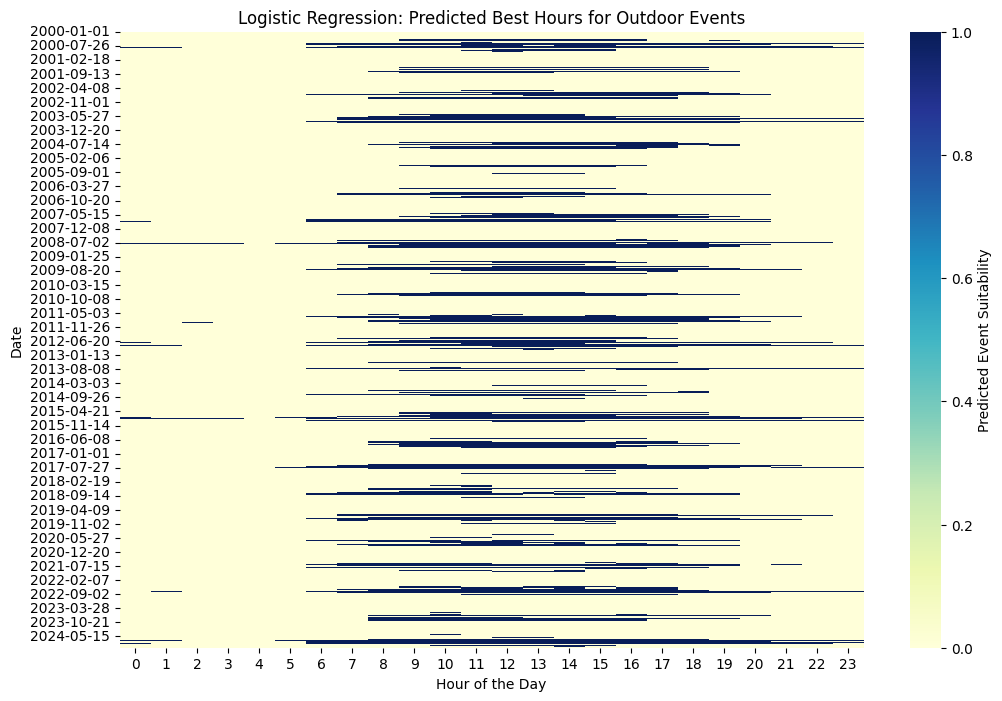

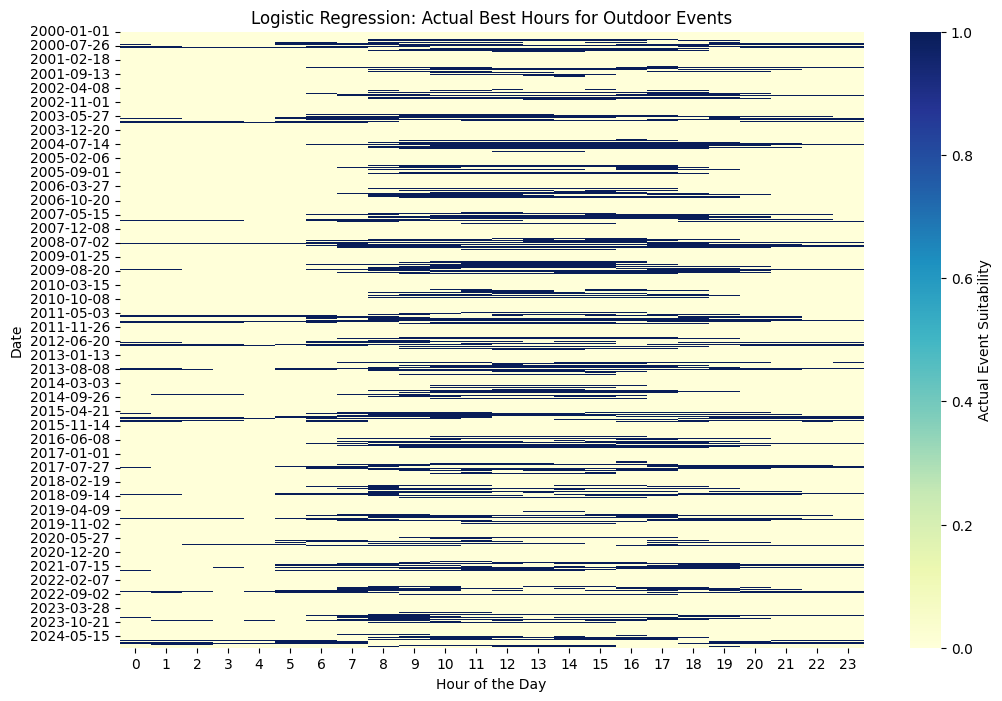

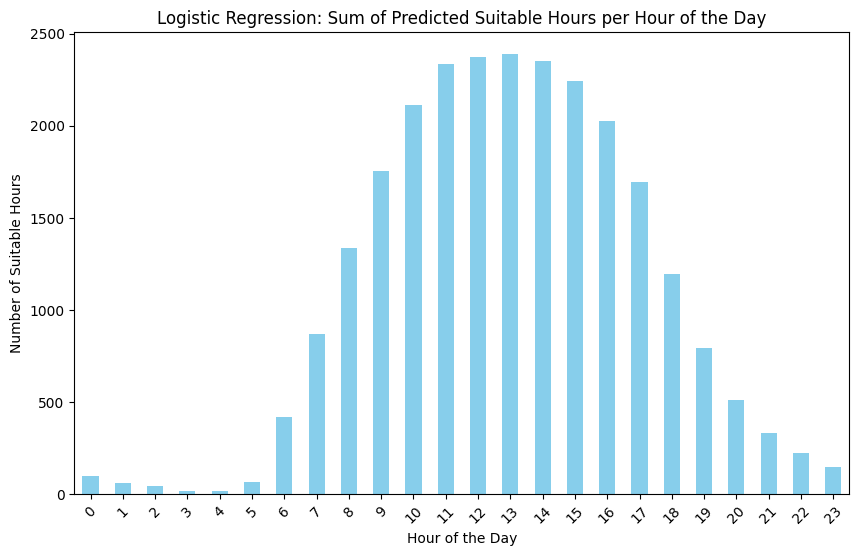

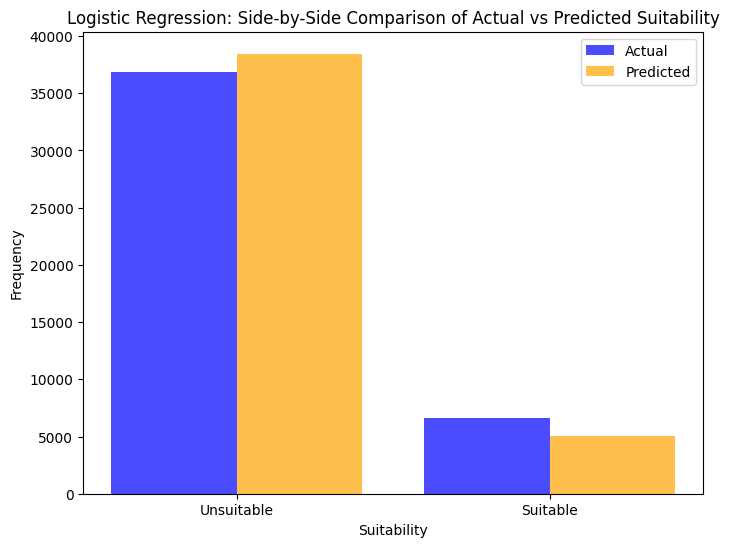

K-Nearest Neighbors - Cross-Validation Scores: [0.99476067 0.99441598 0.99351977 0.99430108 0.99441598]
K-Nearest Neighbors - Average Cross-Validation Score: 0.99

K-Nearest Neighbors - Model Accuracy: 0.99
K-Nearest Neighbors - Mean Absolute Error: 0.01



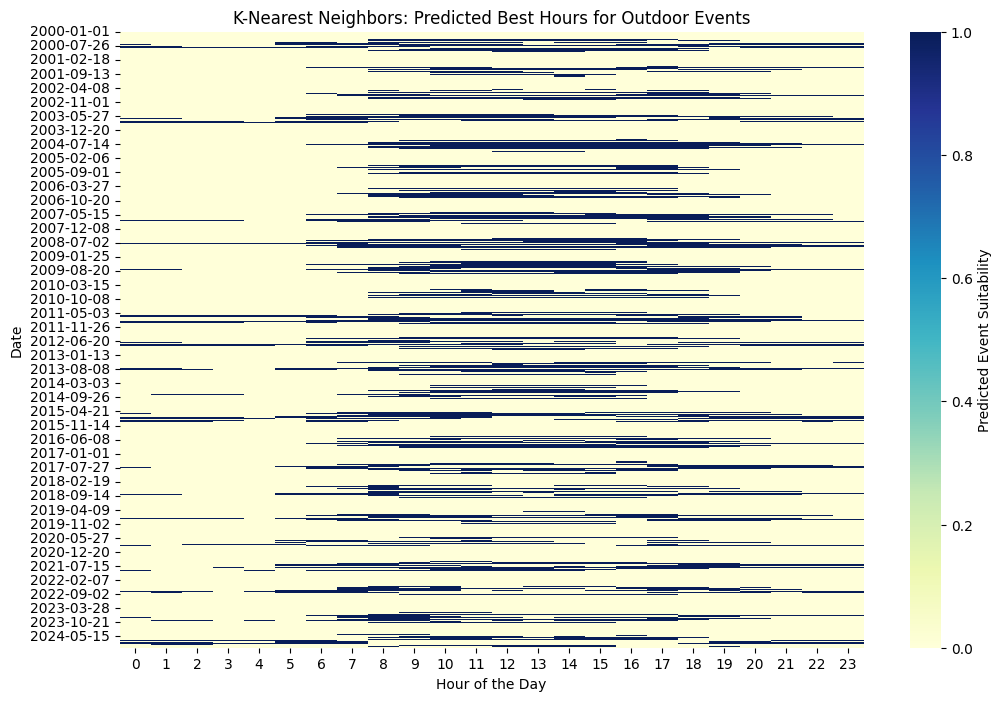

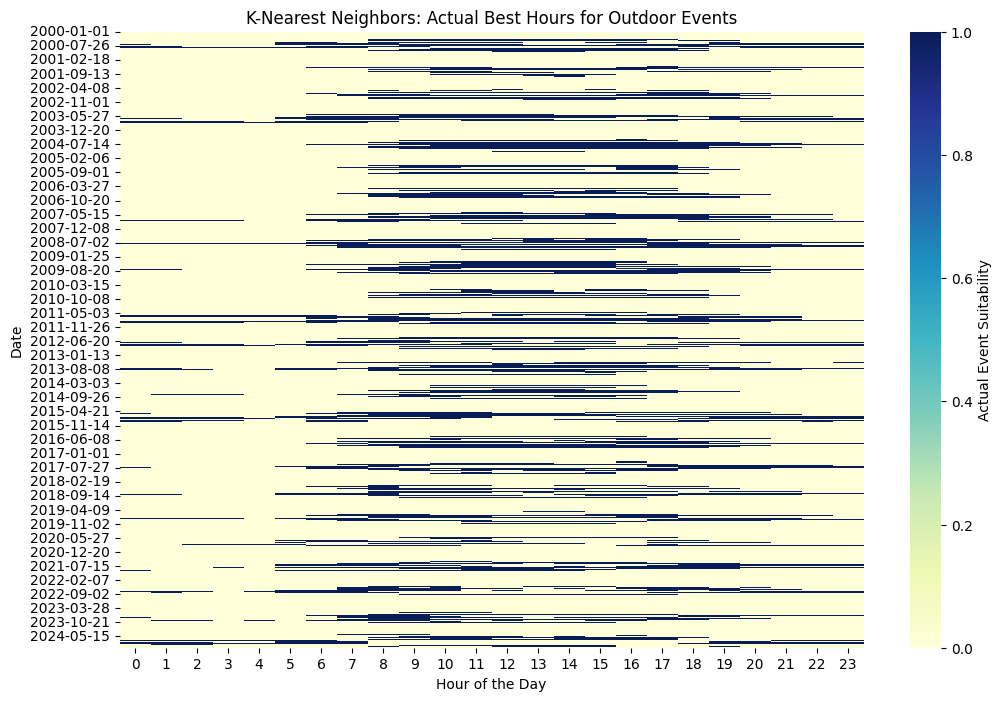

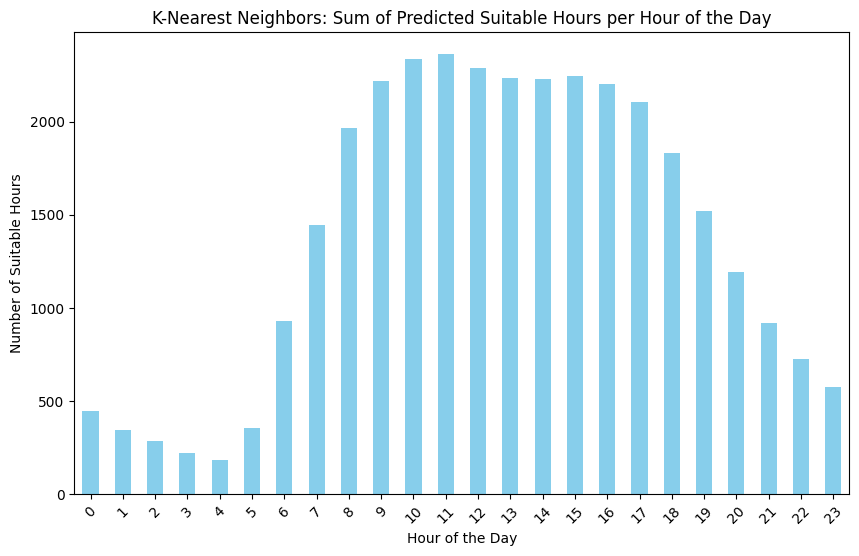

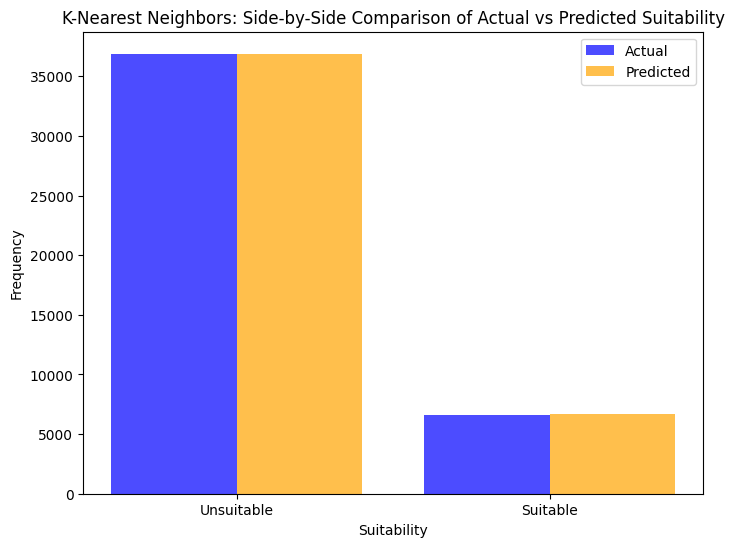

Support Vector Machine - Cross-Validation Scores: [0.97168922 0.97063217 0.96716226 0.97095388 0.96969001]
Support Vector Machine - Average Cross-Validation Score: 0.97

Support Vector Machine - Model Accuracy: 0.97
Support Vector Machine - Mean Absolute Error: 0.03



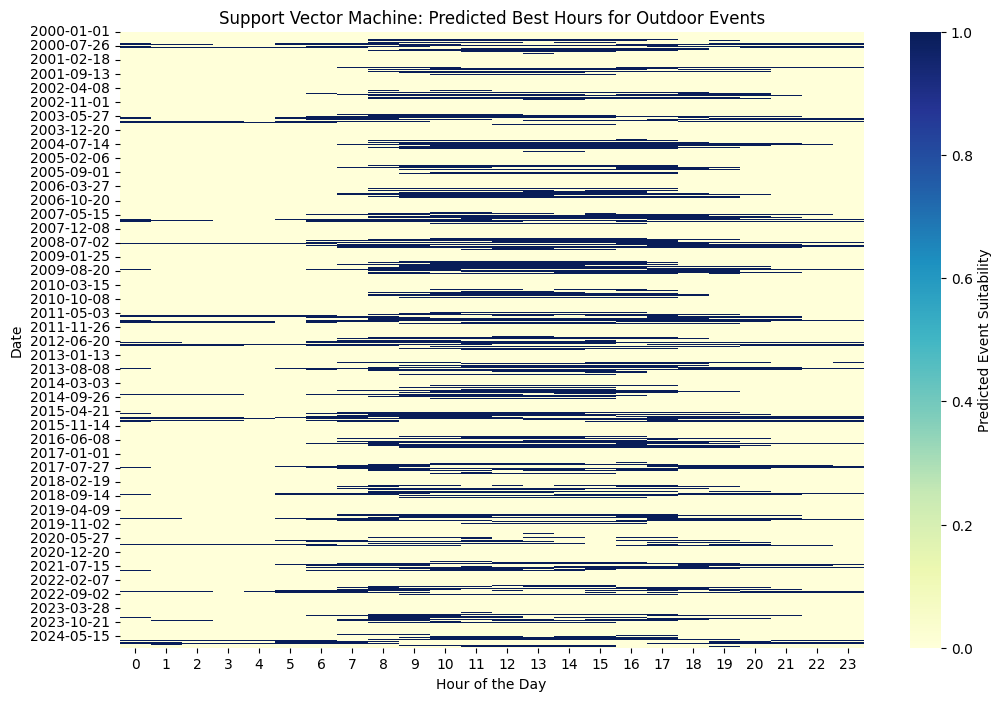

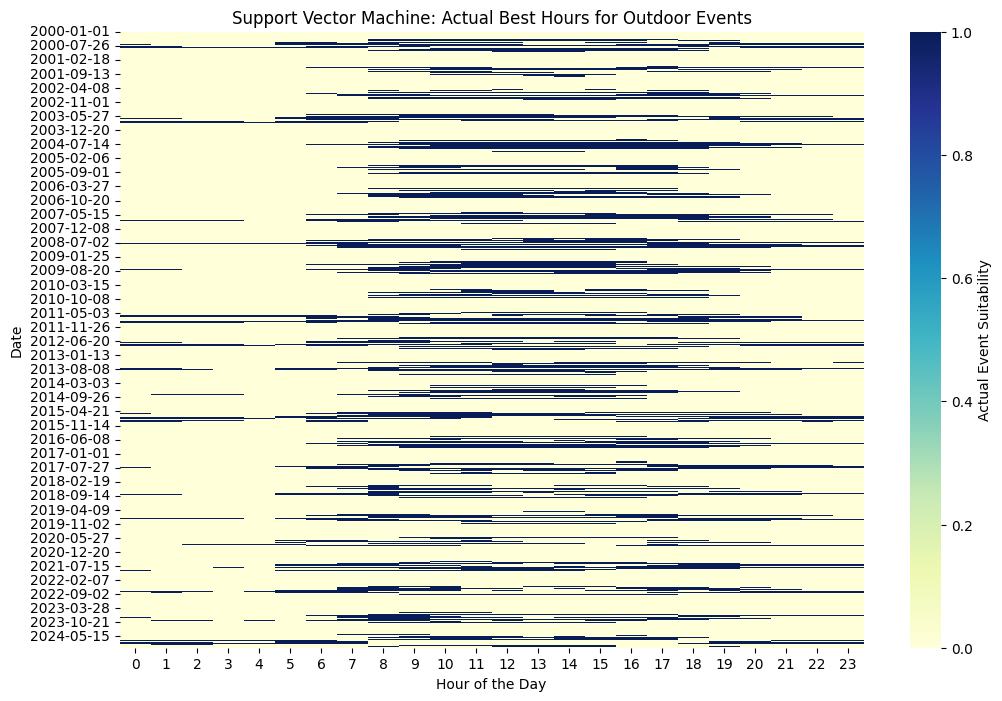

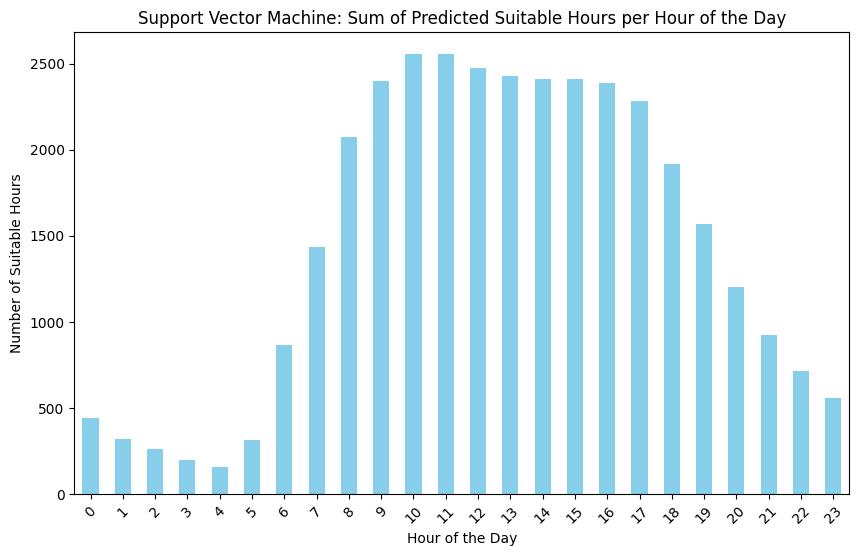

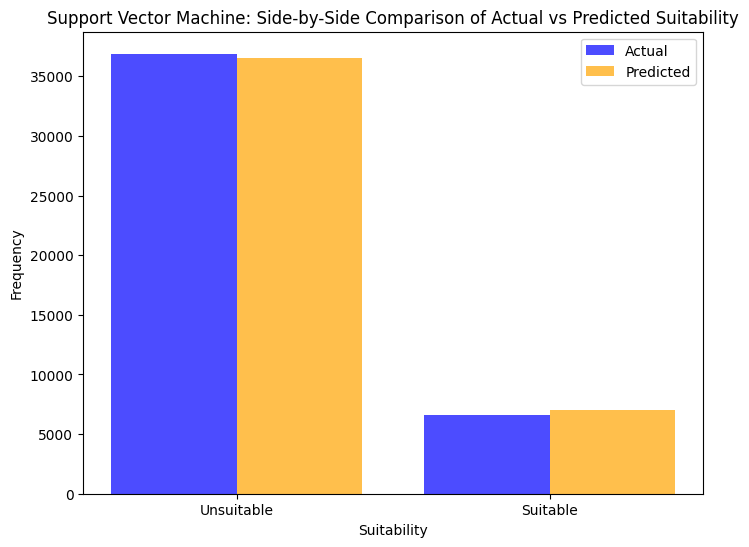

Best Hyperparameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Optimized Random Forest - Accuracy: 1.00
Optimized Random Forest - Mean Absolute Error: 0.00



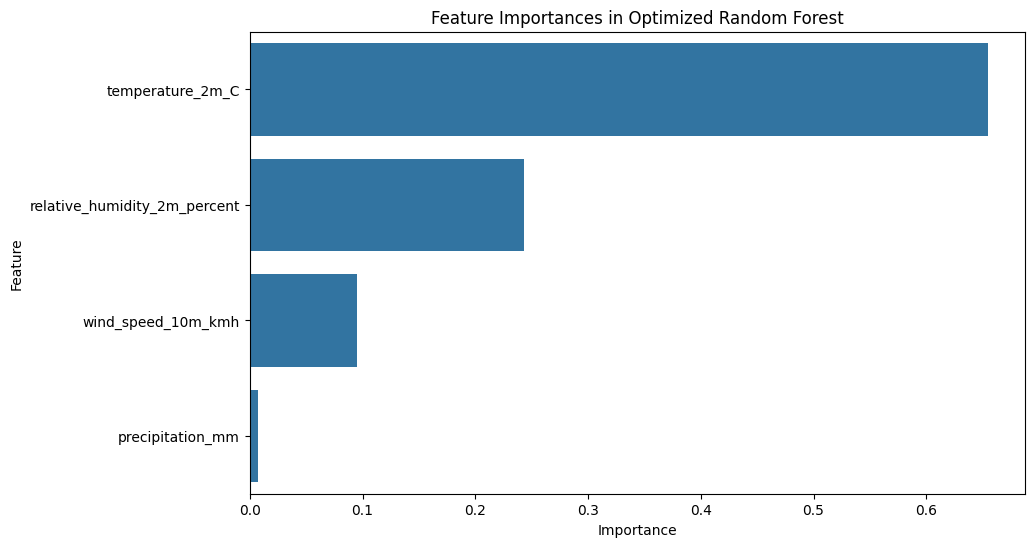

Started at: 2024-11-02 20:37:48.778519.
Duration: 0:28:30.003654
Finished with all the new features comparing to the cell above:
        Cross-validation for model evaluation.
        Hyperparameter tuning using GridSearchCV.
        Feature importance analysis for the Random Forest model.
        Visualizations maintained for all models and their comparisons.


In [2]:
import sys
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Importing WeatherAnalyzer from the analyze_data script
sys.path.append('/workspaces/weather-scraper-analyzer/src/03-data_analysis')
from analyze_data import WeatherAnalyzer

# Setting up the connection to the database
conn = sqlite3.connect(r"/workspaces/weather-scraper-analyzer/data/weather_data.db")
hourly_df = pd.read_sql(r"SELECT * FROM hourly_data", conn)
daily_df = pd.read_sql(r"SELECT * FROM daily_data", conn)

# Dropping the index column
hourly_df = hourly_df.drop(columns='index')
daily_df = daily_df.drop(columns='index')

# Convert 'date' columns to datetime
hourly_df['date'] = pd.to_datetime(hourly_df['date'])
daily_df['date'] = pd.to_datetime(daily_df['date'])

# Setting the date as index
hourly_df = hourly_df.set_index('date')
daily_df = daily_df.set_index('date')

# Initialize WeatherAnalyzer
analyzer = WeatherAnalyzer(hourly_df, daily_df)

# Example Feature Engineering Using WeatherAnalyzer
# Aggregating data to create features (e.g., weekly or monthly averages)
weekly_data = analyzer.aggregate_hourly('week')
monthly_data = analyzer.aggregate_daily('month')

# Creating new features based on weather conditions
hourly_df['temperature_threshold'] = (hourly_df['temperature_2m_C'] > 20) & (hourly_df['temperature_2m_C'] < 30)
hourly_df['humidity_threshold'] = (hourly_df['relative_humidity_2m_percent'] > 30) & (hourly_df['relative_humidity_2m_percent'] < 70)
hourly_df['wind_threshold'] = hourly_df['wind_speed_10m_kmh'] < 15
hourly_df['precipitation_threshold'] = hourly_df['precipitation_mm'] < 1

# Combine features to create a target variable for event suitability
hourly_df['event_suitability'] = (
    hourly_df['temperature_threshold'] &
    hourly_df['humidity_threshold'] &
    hourly_df['wind_threshold'] &
    hourly_df['precipitation_threshold']
).astype(int)

start_time = datetime.now()

# Splitting data into features (X) and target (y)
X = hourly_df[['temperature_2m_C', 'relative_humidity_2m_percent', 'wind_speed_10m_kmh', 'precipitation_mm']]
y = hourly_df['event_suitability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of models to test
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine": SVC(kernel='rbf', C=1.0)
}

# Applying cross-validation and model evaluation
for model_name, model in models.items():
    # Cross-validation scores
    cv_scores = cross_val_score(model, X, y, cv=5)
    print(f"{model_name} - Cross-Validation Scores: {cv_scores}")
    print(f"{model_name} - Average Cross-Validation Score: {cv_scores.mean():.2f}\n")

    # Training the model on the training set
    model.fit(X_train, y_train)

    # Model Evaluation
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"{model_name} - Model Accuracy: {accuracy:.2f}")
    print(f"{model_name} - Mean Absolute Error: {mae:.2f}\n")

    # Visualization 1: Heatmap of Predicted Event Suitability
    hourly_df['predicted_suitability'] = model.predict(X)
    suitability_pivot = hourly_df.pivot_table(values='predicted_suitability', index=hourly_df.index.date, columns=hourly_df.index.hour)

    plt.figure(figsize=(12, 8))
    sns.heatmap(suitability_pivot, cmap='YlGnBu', cbar_kws={'label': 'Predicted Event Suitability'})
    plt.title(f"{model_name}: Predicted Best Hours for Outdoor Events")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Date")
    plt.show()

    # Visualization 2: Heatmap of Actual Event Suitability
    actual_suitability_pivot = hourly_df.pivot_table(values='event_suitability', index=hourly_df.index.date, columns=hourly_df.index.hour)

    plt.figure(figsize=(12, 8))
    sns.heatmap(actual_suitability_pivot, cmap='YlGnBu', cbar_kws={'label': 'Actual Event Suitability'})
    plt.title(f"{model_name}: Actual Best Hours for Outdoor Events")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Date")
    plt.show()

    # Adding 'hour' column to use for grouping
    hourly_df['hour'] = hourly_df.index.hour
    # Visualization 3: Bar Chart of Suitability Predictions
    suitability_counts = hourly_df.groupby('hour')['predicted_suitability'].sum()

    plt.figure(figsize=(10, 6))
    suitability_counts.plot(kind='bar', color='skyblue')
    plt.title(f"{model_name}: Sum of Predicted Suitable Hours per Hour of the Day")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Number of Suitable Hours")
    plt.xticks(rotation=45)
    plt.show()

    # Visualization 4: Comparison of Actual vs Predicted Suitability
    actual_counts = np.bincount(y_test)
    predicted_counts = np.bincount(y_pred)

    x = np.arange(len(actual_counts))

    plt.figure(figsize=(8, 6))
    plt.bar(x - 0.2, actual_counts, width=0.4, color='blue', label='Actual', alpha=0.7)
    plt.bar(x + 0.2, predicted_counts, width=0.4, color='orange', label='Predicted', alpha=0.7)
    plt.xlabel("Suitability")
    plt.ylabel("Frequency")
    plt.title(f"{model_name}: Side-by-Side Comparison of Actual vs Predicted Suitability")
    plt.xticks(x, labels=["Unsuitable", "Suitable"])
    plt.legend()
    plt.show()

# Hyperparameter Tuning Example for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)
print("Best Hyperparameters for Random Forest:", grid_search_rf.best_params_)

# Evaluating the best Random Forest model
best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
best_rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
best_rf_mae = mean_absolute_error(y_test, y_pred_best_rf)
print(f"Optimized Random Forest - Accuracy: {best_rf_accuracy:.2f}")
print(f"Optimized Random Forest - Mean Absolute Error: {best_rf_mae:.2f}\n")

# Feature Importance Analysis
importances = best_rf_model.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances in Optimized Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

end_time = datetime.now()
print(f"Started at: {start_time}.\nDuration: {end_time-start_time}")
print(f"""Finished with all the new features comparing to the cell above:
        Cross-validation for model evaluation.
        Hyperparameter tuning using GridSearchCV.
        Feature importance analysis for the Random Forest model.
        Visualizations maintained for all models and their comparisons.""")

#### **Interpretation of K-Nearest Neighbors (KNN) Model Results**

**High Model Accuracy**:

The K-Nearest Neighbors model achieved an impressive accuracy of 0.99 (99%), indicating that the model correctly predicted event suitability 99% of the time on the test data.

*Low Mean Absolute Error (MAE):*

The model has a mean absolute error of 0.01, which means the average prediction error is very low, signifying that KNN is making predictions very close to the actual values.

*Cross-Validation Scores:*

The cross-validation scores range between 0.9935 and 0.9948, with an average cross-validation score of 0.99. This suggests that the model performs consistently well across different subsets of the data and is robust.

**Visualizations:**

*Heatmaps:* The heatmaps comparing predicted and actual suitability show a strong alignment, meaning the model accurately predicts the most suitable hours for outdoor events.

*Bar Chart:* The bar chart showing the number of suitable hours per hour of the day illustrates how event suitability peaks during midday, likely when weather conditions are optimal.

*Side-by-Side Comparison:* The bar chart comparison of actual vs. predicted suitability shows that KNN effectively mirrors the distribution of the data, with very few discrepancies.

**Why KNN is the Best Choice**

*Performance:* The high accuracy and low error rates demonstrate that KNN handles the data well, even when considering multiple weather variables.

*Consistency:* The consistent performance across cross-validation folds suggests that KNN is not overfitting and generalizes well.

*Simplicity*: KNN is relatively simple to understand and implement, making it a good choice when computational efficiency and interpretability are important.


**Conclusion**
Based on these results, the KNN model is highly effective at predicting suitable hours for outdoor events. It shows both high predictive accuracy and consistency across the data. Given the performance metrics and the stability of KNN, it stands out as the best model for this specific problem compared to others like Logistic Regression, which had lower accuracy, or more complex models like Gradient Boosting, which, although accurate, might be unnecessarily complicated for this dataset.

<font color = 'lightblue'> Seems that **between 9 and 17 is a good period** of outdoor event organizing </font>

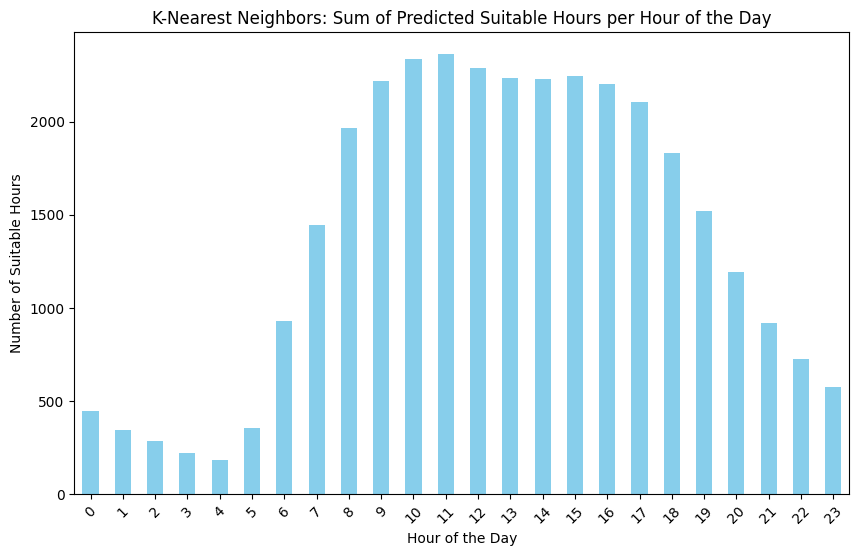 